In [1]:
import os
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
from IPython.display import SVG
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
import pydot
import graphviz

In [2]:
data_dir = "Images/"
img_width, img_height = 224, 224 
channels = 3
batch_size = 64
image_arr_size= img_width * img_height * channels

In [16]:
#capaz hacer esto con image_dataset_from_directory() es mejor 🤷‍♂️
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    shear_range= 0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    rotation_range= 20,
    width_shift_range= 0.2,
    height_shift_range= 0.2,   
    validation_split=0.15,

)

valid_datagen = ImageDataGenerator(
    rescale= 1./255, 
    validation_split=0.15,
)

In [17]:
train_generator = train_datagen.flow_from_directory(  
    data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    subset='training',
    shuffle= True, 
    seed= 1337
) 

valid_generator = valid_datagen.flow_from_directory(
    data_dir,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    subset='validation',
    shuffle= True, 
    seed= 1337
)

Found 17555 images belonging to 120 classes.
Found 3025 images belonging to 120 classes.


In [18]:
num_classes = len(train_generator.class_indices)  
train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = valid_generator.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
nb_train_samples = len(train_generator.filenames) 
nb_valid_samples = len(valid_generator.filenames)

In [5]:
#to check if there is any common photo in train and valid, it is not
list(set(train_generator.filenames).intersection(valid_generator.filenames))

[]

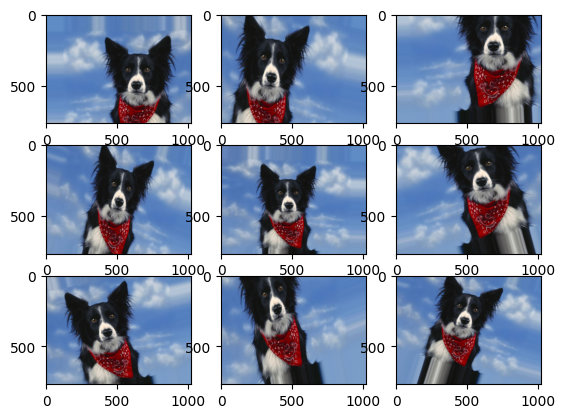

In [57]:
img = load_img('Images/n02106166-Border_collie/n02106166_1056.jpg')
data = img_to_array(img)
samples = expand_dims(data, 0)
it = train_datagen.flow(samples, batch_size=1)

for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0]
    plt.imshow(image)


In [7]:
InceptionV3 = InceptionV3(include_top= False, input_shape= (img_width, img_height, channels), weights= 'imagenet')
InceptionV3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [11]:
model = Sequential()

for layer in InceptionV3.layers:
    layer.trainable= False
#     print(layer,layer.trainable)
    
model.add(InceptionV3)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(120,activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               245880    
Total params: 22,048,664
Trainable params: 245,880
Non-trainable params: 21,802,784
_________________________________________________________________


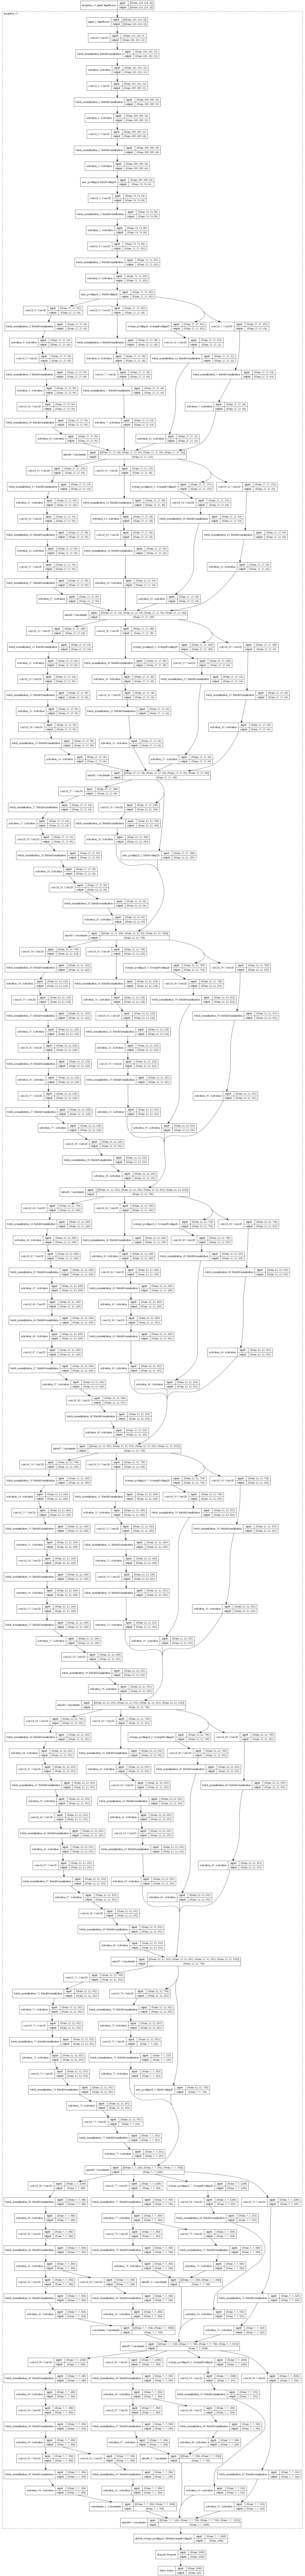

In [47]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

In [18]:
model.compile(optimizer= keras.optimizers.Adam(learning_rate= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [30]:
checkpoint = ModelCheckpoint(
    'baseline_model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    save_freq=1
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=5,
    verbose=1,
    mode='auto'
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint, earlystop, csvlogger,reduceLR]

In [20]:
history = model.fit(
    train_generator, 
    epochs = 20,
    steps_per_epoch = nb_train_samples//batch_size,
    validation_data = valid_generator, 
    validation_steps = nb_valid_samples//batch_size,
    verbose = 2, 
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/30
274/274 - 149s - loss: 3.3609 - accuracy: 0.3011 - val_loss: 1.6561 - val_accuracy: 0.6862

Epoch 00001: val_loss improved from inf to 1.65609, saving model to baseline_model.h5
Epoch 2/30
274/274 - 127s - loss: 1.5748 - accuracy: 0.6263 - val_loss: 0.9537 - val_accuracy: 0.7630

Epoch 00002: val_loss improved from 1.65609 to 0.95370, saving model to baseline_model.h5
Epoch 3/30
274/274 - 132s - loss: 1.1609 - accuracy: 0.6967 - val_loss: 0.7848 - val_accuracy: 0.7816

Epoch 00003: val_loss improved from 0.95370 to 0.78485, saving model to baseline_model.h5
Epoch 4/30
274/274 - 126s - loss: 1.0396 - accuracy: 0.7131 - val_loss: 0.7176 - val_accuracy: 0.7929

Epoch 00004: val_loss improved from 0.78485 to 0.71761, saving model to baseline_model.h5
Epoch 5/30
274/274 - 128s - loss: 0.9630 - accuracy: 0.7275 - val_loss: 0.6811 - val_accuracy: 0.8012

Epoch 00005: val_loss improved from 0.71761 to 0.68114, saving model to baseline_model.h5
Epoch 6/30
274/274 - 131s - loss: 0.916

In [21]:
(eval_loss, eval_accuracy) = model.evaluate(valid_generator, batch_size= batch_size, verbose= 1)
print('Validation Loss: ', eval_loss)
print('Validation Accuracy: ', eval_accuracy)

48/48 [==============================] - 7s 146ms/step - loss: 0.6264 - accuracy: 0.8099
Validation Loss:  0.626414954662323
Validation Accuracy:  0.8099173307418823


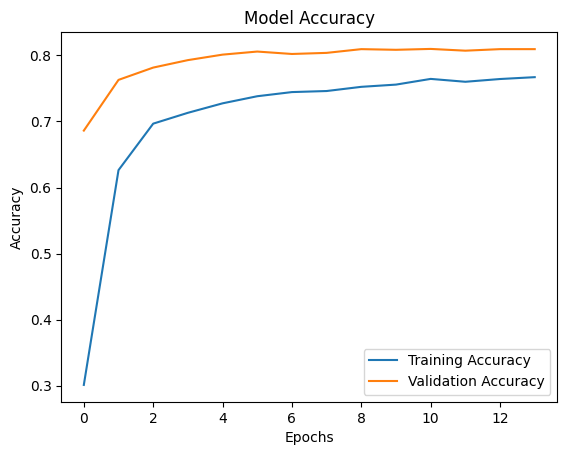

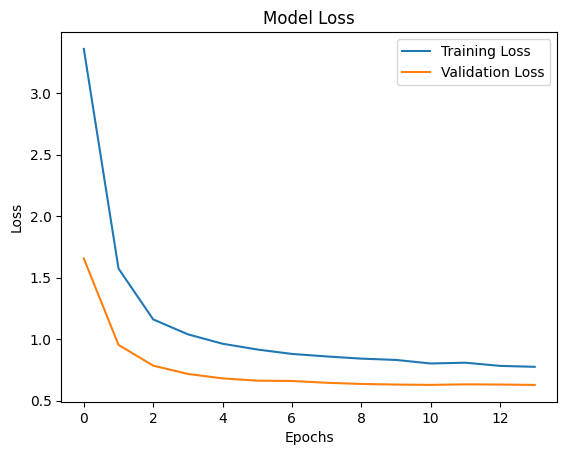

In [22]:
#Plotting
plt.subplot()
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.show()

plt.title('Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.show()

In [21]:
model = tf.keras.models.load_model('baseline_model.h5')

In [51]:
#DO THE REAL TIME TESTING HERE:
img = load_img('test\oris.jpeg', target_size=(224, 224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

# select the maximum posibility of breed
prediction = model.predict(img_array)
y_pred_classes = np.argmax(prediction)
#y_pred_classes

In [52]:
def breed_prediction(prediction_num):
    for k, v in train_generator.class_indices.items():
        if v == prediction_num:
            return k.split("-")[1]

In [53]:
breed_prediction(y_pred_classes)

'Border_collie'

In [42]:
#keep dict to check references
train_generator.class_indices

{'n02085620-Chihuahua': 0,
 'n02085782-Japanese_spaniel': 1,
 'n02085936-Maltese_dog': 2,
 'n02086079-Pekinese': 3,
 'n02086240-Shih-Tzu': 4,
 'n02086646-Blenheim_spaniel': 5,
 'n02086910-papillon': 6,
 'n02087046-toy_terrier': 7,
 'n02087394-Rhodesian_ridgeback': 8,
 'n02088094-Afghan_hound': 9,
 'n02088238-basset': 10,
 'n02088364-beagle': 11,
 'n02088466-bloodhound': 12,
 'n02088632-bluetick': 13,
 'n02089078-black-and-tan_coonhound': 14,
 'n02089867-Walker_hound': 15,
 'n02089973-English_foxhound': 16,
 'n02090379-redbone': 17,
 'n02090622-borzoi': 18,
 'n02090721-Irish_wolfhound': 19,
 'n02091032-Italian_greyhound': 20,
 'n02091134-whippet': 21,
 'n02091244-Ibizan_hound': 22,
 'n02091467-Norwegian_elkhound': 23,
 'n02091635-otterhound': 24,
 'n02091831-Saluki': 25,
 'n02092002-Scottish_deerhound': 26,
 'n02092339-Weimaraner': 27,
 'n02093256-Staffordshire_bullterrier': 28,
 'n02093428-American_Staffordshire_terrier': 29,
 'n02093647-Bedlington_terrier': 30,
 'n02093754-Border_terr